In [18]:
import os, sys
from pathlib import Path
import torch

macaw_path = Path(os.getcwd()).parent.parent.parent
sys.path.append(str(macaw_path) +'/')

ncomps = 60
model_comps =500
dr_method = 'KPCA'


test_path = train_path = macaw_path/'splits'/f'test_hc_data_KPCA_{ncomps}.pkl'
model_base_path = macaw_path/'models'/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [20]:
import pickle

with open(test_path, 'rb') as f:
    test = pickle.load(f)
    
disease = test['disease']
bias = test['bias']
test_imgs = test['imgs']

encoded_data = test['encoded_data']
kpca = test['kpca']

FileNotFoundError: [Errno 2] No such file or directory: '/home/splits/test_hc_data_KPCA_60.pkl'

In [21]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

FileNotFoundError: [Errno 2] No such file or directory: '/home/models/KPCA_500/60/hyperparameters.pkl'

In [22]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = kpca.inverse_transform(latent_enc)
    return age+min_age,bmi,imgs

In [23]:
sample_imgs = test_imgs[:5,:]
t = kpca.transform(sample_imgs)
X_recon = kpca.inverse_transform(t)

NameError: name 'test_imgs' is not defined

NameError: name 'sample_imgs' is not defined

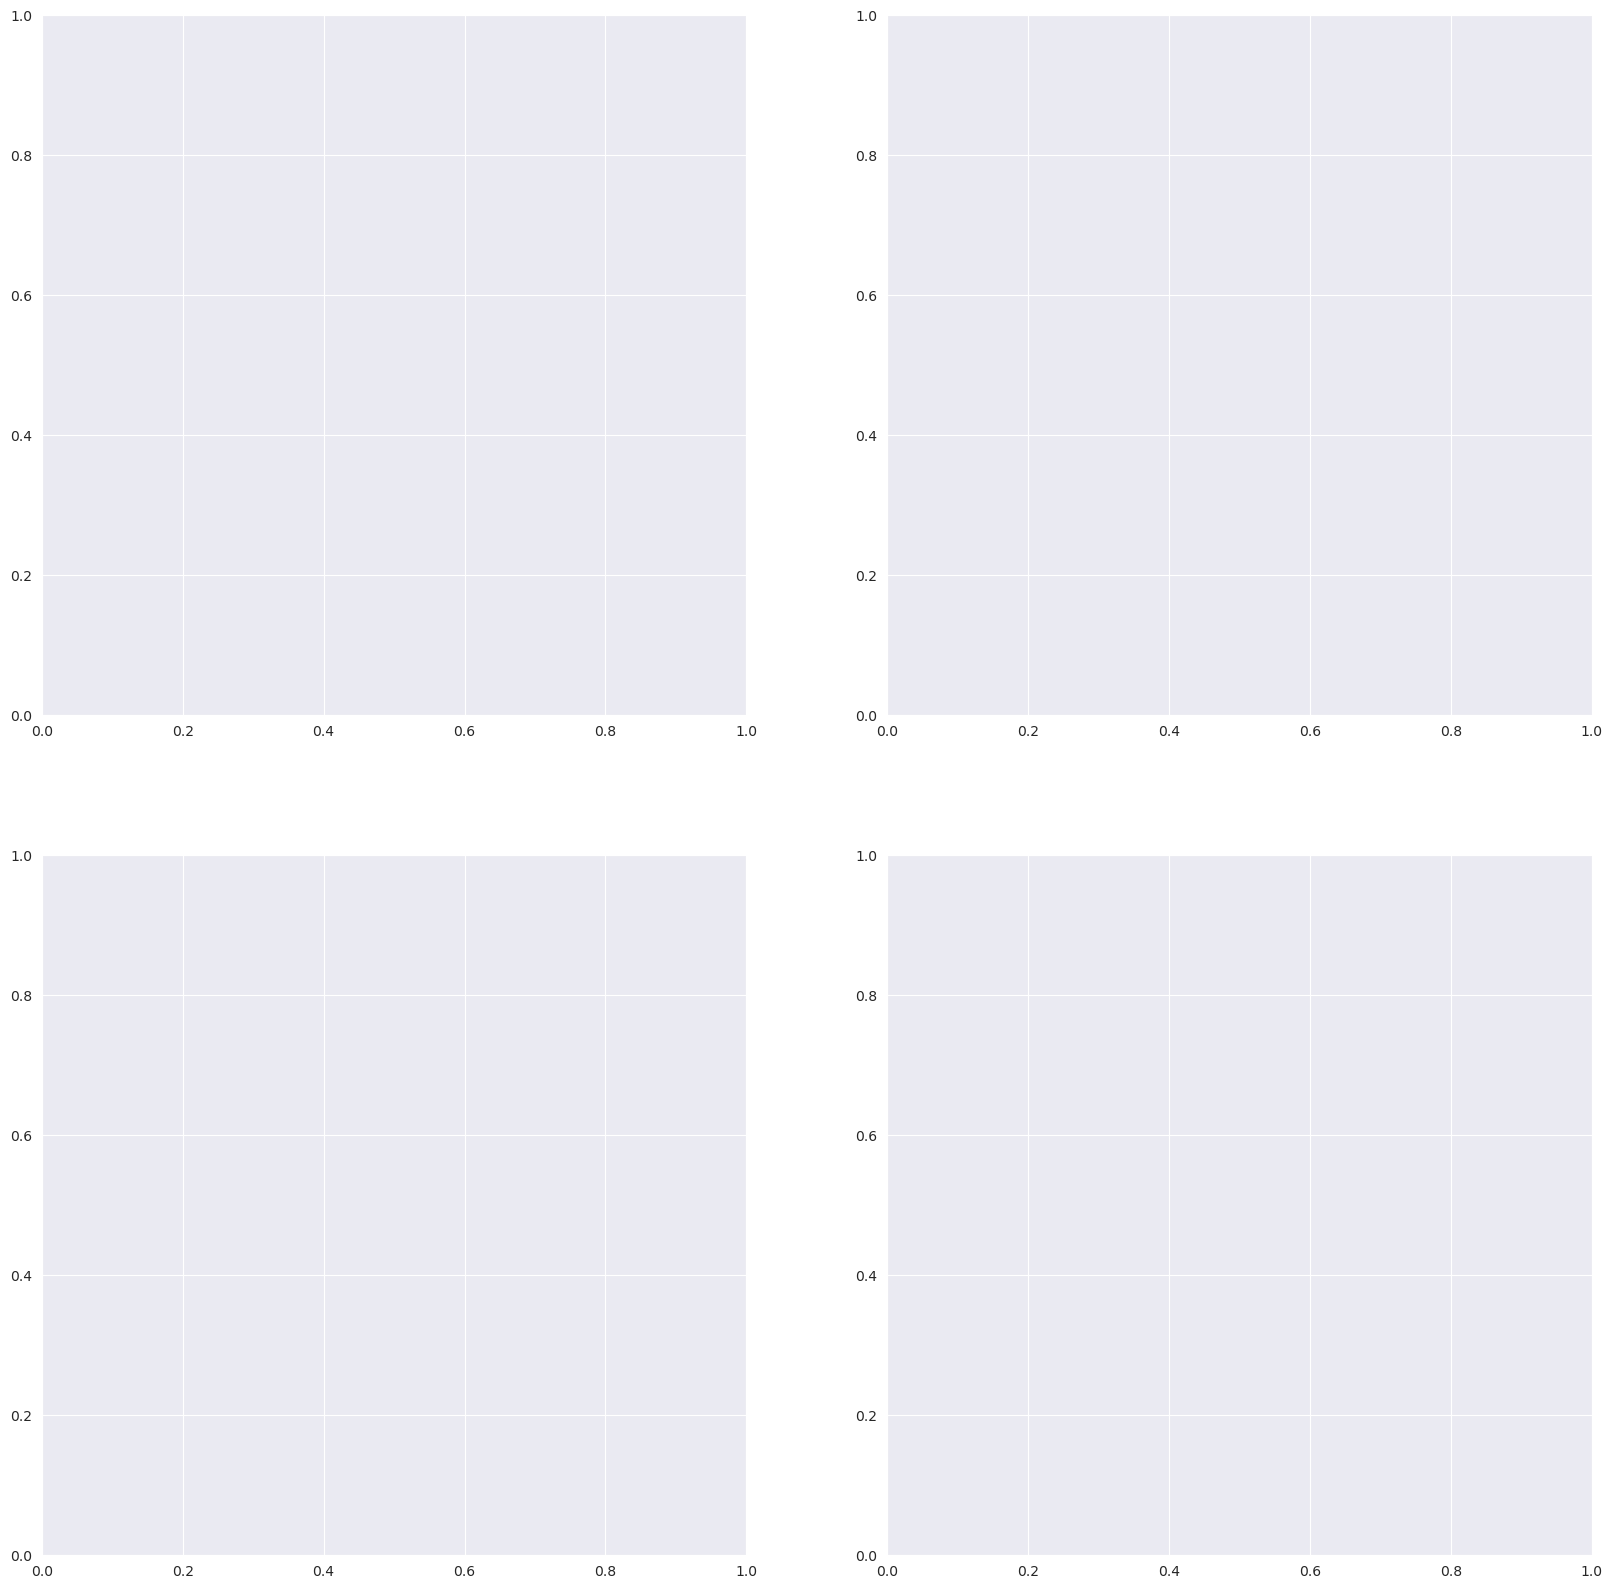

In [24]:
import utils.visualize as vis

plt.rcParams["figure.figsize"] = 20,5

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in diff], clim=(-1,1), cols=5, cmap='seismic')
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in rr], clim=(0,1), cols=5)

NameError: name 'disease' is not defined

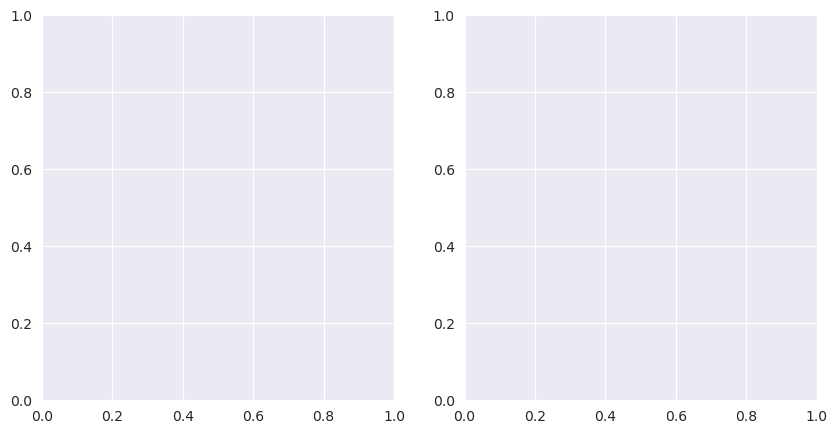

In [31]:
import seaborn as sns

sb = 2
fig, axs = plt.subplots(1,sb, figsize=(sb*5,5))

sns.histplot(disease,ax=axs[0],fill=True)
axs[0].set(title = "Disease")
sns.histplot(bias,ax=axs[1],fill=True)
axs[1].set(title = "Bias")

## Generative Sampling

In [7]:
def make_img(x):
    img = np.rot90((255*x/np.max(x)).reshape(crop_size,crop_size))
    return np.clip(img,0, 255).astype('uint8')

In [8]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

## Random sampling

In [ ]:
from IPython.display import display, clear_output
import torch

for kk  in range(20):
    ncauses=3
    nsamples=1
    samples_enc = np.zeros((nsamples,ncomps))
    # save_name = f'/data/Papers/TMI-MACAW/exp3/sampling/random/{kk}'


    macaw = torch.load(model_base_path/'0.pt')
    ss = macaw.sample(nsamples)
    ss

    int_vals={}

    samples_causes = ss[:,:ncauses]
    samples_enc[:,:nevecs] = ss[:,ncauses:]
    int_vals[0] = samples_causes[0,0]
    int_vals[1] = samples_causes[0,1]
    int_vals[2] = samples_causes[0,2]

    for i,v in enumerate(ss[0,nevecs-nbasecomps+ncauses:]):
        int_vals[i+ncauses] = v

    int_vals

    frames = []
    for ev in range(nevecs-nbasecomps,500,nevecs-nbasecomps):      
        print(ev)
        try:    
            macaw = torch.load(model_base_path/f'{ev}.pt')
            ss = macaw.intervene_parent(int_vals,n_samples=nsamples)

            samples_enc[:,ev:ev+nevecs] = ss[:,ncauses:]

            for i,v in enumerate(ss[0,nevecs-nbasecomps+ncauses:]):
                int_vals[i+ncauses] = v

            print(f'Model loaded: macaw_ukbb_KPCA_{ev}')

            re = recons(samples_causes[:,1],samples_causes[:,2],samples_enc)      

            img = make_img(re[2])


            frames.append(img)         
            sex_t = ['Male' if round(s) else 'Female' for s in samples_causes[:,0]]
            titles_sam = [f'Sex:{s}, Age:{a}, BMI:{np.round(b)}' for s,a,b in zip(sex_t, re[0],re[1])]

            fig, ax1 = plt.subplots(1,1)
            a = ax1.imshow(img, cmap='gray')
            ax1.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=titles_sam[0])
            plt.savefig(save_name+'.pdf')        
            plt.close()        

            clear_output()
            display(fig)
        except Exception as e:
            print(e)    

    make_gif(frames,save_name+'.gif')

## Interventional sampling

In [ ]:
from IPython.display import display, clear_output
import torch

for kk  in range(5):
    ncauses=3
    nsamples=1
    samples_enc = np.zeros((nsamples,ncomps))
    save_name = f'/data/Papers/TMI-MACAW/exp3/sampling/Age75/{kk}'
    
    sex_i = 0
    age_i = 75
    bmi_i = 20
    pca0_i = 0.08

    int_vals ={1:age_i-min_age}
    
    frames = []
    for ev in range(0,400,nevecs-nbasecomps):      
        print(ev)
        try:    
            macaw = torch.load(model_base_path/f'{ev}.pt')
            ss = macaw.intervene_parent(int_vals,n_samples=nsamples)
            
            samples_causes = ss[:,:ncauses]
            int_vals[0] = samples_causes[0,0]
            int_vals[1] = samples_causes[0,1]
            int_vals[2] = samples_causes[0,2]
    
            samples_enc[:,ev:ev+nevecs] = ss[:,ncauses:]

            for i,v in enumerate(ss[0,nevecs-nbasecomps+ncauses:]):
                int_vals[i+ncauses] = v

            print(f'Model loaded: macaw_ukbb_KPCA_{ev}')

            re = recons(samples_causes[:,1],samples_causes[:,2],samples_enc)      

            img = make_img(re[2])


            frames.append(img)         
            sex_t = ['Male' if round(s) else 'Female' for s in samples_causes[:,0]]
            titles_sam = [f'Sex:{s}, Age:{a}, BMI:{np.round(b)}' for s,a,b in zip(sex_t, re[0],re[1])]

            fig, ax1 = plt.subplots(1,1)
            a = ax1.imshow(img, cmap='gray')
            ax1.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=titles_sam[0])
            plt.savefig(save_name+'.pdf')        
            plt.close()        

            clear_output()
            display(fig)
        except Exception as e:
            print(e)    

    make_gif(frames,save_name+'.gif')

## Counterfactuals

In [ ]:
for kk in range(10):
    save_name = f'/data/Papers/TMI-MACAW/exp3/counterfactuals/bmi35/{kk}.pdf'
    cf_vals = {2:35}
    nsamples = 5

    rands = np.random.randint(0,encoded_data.shape[0],nsamples)
    d_obs = test_imgs[rands,:]
    encoded_obs = encoded_data[rands,:]

    sex_obs = sex[rands]
    age_obs = age[rands]
    bmi_obs = bmi[rands]
    residuals = d_obs - kpca.inverse_transform(encoded_obs)

    cf = np.zeros((nsamples,ncomps))  
    
    
    for ev in range(0,ncomps-nbasecomps,nevecs-nbasecomps):
        ed =  encoded_obs[:,ev:ev+nevecs]
        X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], bmi_obs[:,np.newaxis], ed])
        try:
            macaw = torch.load(model_base_path/f'{ev}.pt')
            cc = macaw.counterfactual(X_obs,cf_vals)
        except Exception as e:
            print(e,"Using original")
            cc[:,ncauses:] = X_obs[:,ncauses:].copy()

        cf[:,ev:ev+nevecs] = cc[:,ncauses:]


    re_obs = recons(X_obs[:,1],X_obs[:,2],X_obs[:,3:])
    re_cf = recons(cc[:,1],cc[:,2],cf)

    re_cf_resd = re_cf[2] + residuals

    diff = d_obs - re_cf_resd

    fig,axs = plt.subplots(3,nsamples, figsize=(18,10))

    sex_obs = ['Male' if np.round(x) else 'Female' for x in X_obs[:,0]]
    sex_cf = ['Male' if np.round(x) else 'Female' for x in cc[:,0]]

    for i in range(nsamples):
        axs[0,i].imshow(np.rot90(d_obs[i].reshape(crop_size,crop_size)),cmap='gray')
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Sex:{sex_obs[i]}, Age:{re_obs[0][i]}, BMI:{np.round(re_obs[1][i])}')

        axs[1,i].imshow(make_img(re_cf_resd[i]),cmap='gray')
        axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Sex:{sex_cf[i]}, Age:{re_cf[0][i]}, BMI:{np.round(re_cf[1][i])}')

        axs[2,i].imshow(np.rot90(diff[i].reshape(crop_size,crop_size)),cmap='seismic', clim=[-1,1])
        axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.savefig(save_name)
    plt.show()

## Age Progression

In [42]:
for kk in range(1):
    save_name = f'/data/Papers/TMI-MACAW/exp3/counterfactuals/progress/{kk}.pdf'
    nsamples = 2

    rands = np.random.choice(np.where(age <5)[0], nsamples)
    rands = [3394,3394]    
    d_obs = test_imgs[rands,:]
    encoded_obs = encoded_data[rands,:]

    sex_obs = sex[rands]
    age_obs = age[rands]
    bmi_obs = bmi[rands]
    residuals = d_obs - kpca.inverse_transform(encoded_obs)
    
    fig,axs = plt.subplots(2,6, figsize=(20,6))
    plt.subplots_adjust(wspace=0, hspace=0)

    i=0

    axs[0,i].imshow(np.rot90(d_obs[i].reshape(crop_size,crop_size)),cmap='gray')
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Age:{re_obs[0][i]}')
    
    diff = d_obs - d_obs
    axs[1,0].imshow(np.rot90(diff[i].reshape(crop_size,crop_size)),cmap='seismic', clim=[-1,1])
    axs[1,0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    
    
    for c,cf_vals in enumerate([{1:10},{1:15},{1:20},{1:25},{1:30}]):

        cf = np.zeros((nsamples,ncomps)) 
        print(cf_vals)

        for ev in range(0,ncomps-nbasecomps,nevecs-nbasecomps):
            ed =  encoded_obs[:,ev:ev+nevecs]
            X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], bmi_obs[:,np.newaxis], ed])
            try:
                macaw = torch.load(model_base_path/f'{ev}.pt')
                cc = macaw.counterfactual(X_obs,cf_vals)
            except Exception as e:
                print(e,"Using original")
                cc[:,ncauses:] = X_obs[:,ncauses:].copy()

            cf[:,ev:ev+nevecs] = cc[:,ncauses:]


        re_obs = recons(X_obs[:,1],X_obs[:,2],X_obs[:,3:])
        re_cf = recons(cc[:,1],cc[:,2],cf)

        re_cf_resd = re_cf[2] + residuals

        diff = d_obs - re_cf_resd

        sex_obs_str = ['Male' if np.round(x) else 'Female' for x in X_obs[:,0]]
        sex_cf = ['Male' if np.round(x) else 'Female' for x in cc[:,0]]
        
        axs[0,c+1].imshow(np.rot90(re_cf_resd[i].reshape(crop_size,crop_size)),cmap='gray')
        axs[0,c+1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Age:{re_cf[0][i]}')
        # axs[0,c+1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Sex:{sex_cf[i]}, Age:{re_cf[0][i]}, BMI:{np.round(re_cf[1][i])}')

        axs[1,c+1].imshow(np.rot90(diff[i].reshape(crop_size,crop_size)),cmap='seismic', clim=[-1,1])
        axs[1,c+1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.savefig(save_name)
    plt.show()

In [40]:
plt.savefig(save_name)

In [34]:
re_obs

## Classification

In [8]:
idx = 0
macaw = torch.load(model_base_path/f'{idx}.pt')
X_test = np.hstack([sex[:,np.newaxis], age[:,np.newaxis], bmi[:,np.newaxis], encoded_data[:,idx:nevecs+idx]])

In [9]:
encoded_data

In [ ]:
probs=[]
for i in range(age_bins):
    X_test[:,1] = i
    probs.append(macaw.log_likelihood(X_test))

In [ ]:
pexp = np.exp(np.array(probs))
pexp_sum = np.sum(pexp,axis=0)
p = pexp/pexp_sum

In [ ]:
pred_labels = np.argmax(probs, axis=0)

In [ ]:
sns.histplot(age, bins=age_bins)
sns.histplot(pred_labels,bins=age_bins)

In [ ]:
l = np.array(probs)[:,100]
plt.bar(np.arange(36)+min_age,l-np.min(l))

In [ ]:
import pandas as pd
ll = pd.DataFrame({'pred': l-np.min(l), 'age': np.arange(age_bins)+min_age})

In [ ]:
pal = sns.color_palette("blend:#7AB,#EDA", len(l))
rank = l.argsort().argsort() 

In [ ]:
fig,axs = plt.subplots(1,1, figsize=(4,4))

sns.barplot(ll, x='age', y='pred', palette=np.array(pal)[rank], ax=axs)
axs.set(xticklabels=[int(i+min_age) for i in range(age_bins)], yticklabels=[], xticks=[i for i in range(0,age_bins,5)], yticks=[], 
        title=f'Predicted = 71, Actual = 75', xlabel='Age', ylabel='Likelihood')
plt.savefig('/data/Papers/TMI-MACAW/exp3/classification/barplot.pdf')
plt.show()


In [ ]:
np.argmax(l) + min_age

In [ ]:
age[100]+min_age

In [ ]:
fig,axs = plt.subplots(1,1, figsize=(4,4))
diff = age-pred_labels-1
sns.histplot(diff, bins=age_bins, color='C4', ax=axs)

axs.set(yticklabels=[], xticks=[i for i in range(-20,25,5)], yticks=[], 
        title=f'Difference between actual and predicted age', xlabel='Difference', ylabel='Count')
plt.savefig('/data/Papers/TMI-MACAW/exp3/classification/error.pdf')
plt.show()

In [ ]:
np.mean(np.abs(pred_labels+1 - age))

In [ ]:
np.mean(np.abs(20*np.ones_like(age) - age))

In [ ]:
np.corrcoef(age, pred_labels)

## Outliers

In [22]:
test_probs = macaw.log_likelihood(X_test)

In [23]:
sorted_idx = np.argsort(test_probs)

In [32]:
outliers = test_imgs[sorted_idx[:10]].astype('f')
sex_out = ['Male' if np.round(x) else 'Female' for x in sex[sorted_idx[:10]]]
age_out = age[sorted_idx[:10]] +min_age
bmi_out = np.round(bmi[sorted_idx[:10]])
bmi_out

In [17]:
outliers[1].shape

In [48]:
fig,axs = plt.subplots(2,5,figsize=(20,8))

axs = np.ravel(axs)
for ii in range(10):
    axs[ii].imshow(np.rot90(outliers[ii].reshape(crop_size,crop_size)),cmap='gray')
    axs[ii].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[],title=f'{sex_out[ii]},{age_out[ii]}, BMI:{bmi_out[ii]}')

plt.subplots_adjust(top=0.58,bottom=0,left=0,right=0.5, wspace=0, hspace=0)
plt.savefig('/data/Papers/TMI-MACAW/exp3/exp3-out.pdf') 


## Linear Regression

In [ ]:
with open(model_base_path/'lr.pkl', 'rb') as f:
    lr = pickle.load(f)
    
reg = lr['reg']

X = np.hstack([sex[:,np.newaxis], bmi[:,np.newaxis], encoded_data[:,idx:nevecs+idx]])
X.shape

In [ ]:
pred_labels_lr  = reg.predict(X)

In [ ]:
np.mean(np.abs(pred_labels_lr - age))

In [ ]:
sns.histplot(age, bins=age_bins)
sns.histplot(pred_labels,bins=age_bins)
sns.histplot(pred_labels_lr,bins=age_bins)

In [ ]:
sns.histplot(age-pred_labels_lr, bins=age_bins)

In [ ]:
sa = macaw.model.priors[1][1].sample((4078,))

In [ ]:
sns.histplot(sa.cpu().numpy(), bins=age_bins)

In [ ]:
X_test.shape

In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(X_test, test_size=0.1, random_state=0, stratify=X_test[:,1])

In [ ]:
train.shape

In [ ]:
pred_labels_lr

In [ ]:
test_vals = [4.97,5.047,5.012,5.1,5.11]

In [ ]:
np.mean(test_vals)

In [ ]:
np.std(test_vals)